## Imports

In [13]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

## Get the data

In [14]:
df = pd.read_csv('GooglePlay.csv')

## prepare numerical data

In [15]:
# get numerical columns
columns = df.columns
numerical_columns = {"Rating": df['Rating'],
                     "Reviews": df['Reviews'],
                     "Size": df['Size'],
                     "Installs": df['Installs'],
                     "Price": df['Price']}
# we will extract the numbers and store the cleaned data in the dict below
cleaned_numerical_columns = {}
# drop missing data = NoN rows
for col in numerical_columns.keys():
    numerical_columns[col].dropna(inplace=True)

## check what is the structure of data in each column

In [16]:
for col_name in numerical_columns.keys():
    data_without_digits = np.array([])
    for data in numerical_columns[col_name]:
        data_without_digits = np.append(data_without_digits, re.sub(r'\d+', '', str(data)))

    # save each structure once
    data_without_digits = np.unique(data_without_digits)
    print(f"column <{col_name}>, extera characters:", data_without_digits, end='\n')

column <Rating>, extera characters: ['.']
column <Reviews>, extera characters: ['']
column <Size>, extera characters: ['.M' '.k' 'M' 'Varies with device' 'k']
column <Installs>, extera characters: ['' '+' ',+' ',,+' ',,,+']
column <Price>, extera characters: ['' '$. ']


## Add 'Rating' and 'Review' columns in cleaned_numerical_columns, because they're already clean

In [17]:
cleaned_numerical_columns['Rating'] = numerical_columns['Rating']
cleaned_numerical_columns['Reviews'] = numerical_columns['Reviews']

## 'Size' column: Remove not numerical data

In [18]:
pattern = r'^\d+(\.\d+)?[Mk]$'
for index, data in enumerate(numerical_columns['Size']):
    if not (re.match(pattern, data)):
        numerical_columns['Size'].drop(index, inplace=True)

## 'Size' column: Extract numbers from combined data

In [19]:
def convert_to_integer(data):
    if data.endswith('M'):
        return int(float(data[:-1]) * 1e6)  # Convert M to millions
    elif data.endswith('k'):
        return int(float(data[:-1]) * 1e3)  # Convert k to thousands
    else:
        return int(data)


# convert combined data into integer
cleaned_numerical_columns['Size'] = numerical_columns['Size'].apply(convert_to_integer)

## 'Installs' column: remove extra characters like ',' and '+'

In [20]:
cleaned_numerical_columns['Installs'] = numerical_columns['Installs'].apply(lambda x: int(''.join(filter(str.isdigit, x))))

## 'Price' column: remove $

In [21]:
cleaned_numerical_columns['Price'] = numerical_columns['Price'].apply(lambda x: float(x.replace('$', '')))

## analyse columns

In [22]:
# create a dict to store mean, max,... values for each attr
analyse_attrs = {key: [] for key in cleaned_numerical_columns.keys()}

for key in cleaned_numerical_columns.keys():
    # get the data of a column/attr
    data = cleaned_numerical_columns[key]
    attr_name = key
    attr_type = type(data[0])
    value_range = (data.min(), data.max())
    min_val = data.min()
    max_val = data.max()
    mean_val = data.mean()
    mode_val = data.mode()[0]
    median_val = data.median()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)].tolist()
    analyse_attrs[key] = [attr_name, attr_type, value_range, min_val, max_val, mean_val, mode_val, median_val, outliers]

In [23]:
# save the result dataframe
labels = ['attr_name', 'attr_type', 'value_range', 'min_val', 'max_val', 'mean_val', 'mode_val', 'median_val', 'outliers']
analyse_attrs = pd.DataFrame(analyse_attrs, index=labels)
analyse_attrs.T.to_csv('analyse_attrs.csv', index=False)
analyse_attrs.T

,attr_name,attr_type,value_range,min_val,max_val,mean_val,mode_val,median_val,outliers
Rating,Rating,<class 'numpy.float64'>,"(1.0, 5.0)",1.0,5.0,4.191757,4.4,4.3,"[3.2, 3.2, 3.1, 3.2, 3.2, 2.6, 3.1, 3.0, 1.9, ..."
Reviews,Reviews,<class 'numpy.int64'>,"(0, 78158306)",0,78158306,444152.896033,0,2094.0,"[215644, 194216, 224399, 295221, 174531, 27192..."
Size,Size,<class 'numpy.int64'>,"(8500, 100000000)",8500,100000000,21516529.515582,11000000,13000000.0,"[73000000, 77000000, 70000000, 77000000, 84000..."
Installs,Installs,<class 'numpy.int64'>,"(0, 1000000000)",0,1000000000,15464338.882565,1000000,100000.0,"[50000000, 100000000, 100000000, 1000000000, 5..."
Price,Price,<class 'numpy.float64'>,"(0.0, 400.0)",0.0,400.0,1.027368,0.0,0.0,"[4.99, 4.99, 4.99, 4.99, 3.99, 3.99, 6.99, 1.4..."


## BoxPlot for outliers

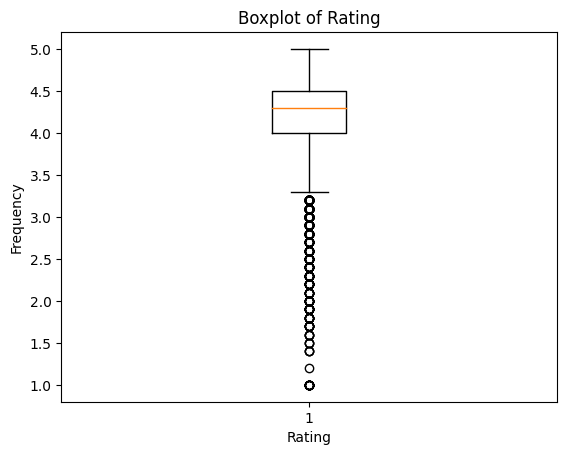

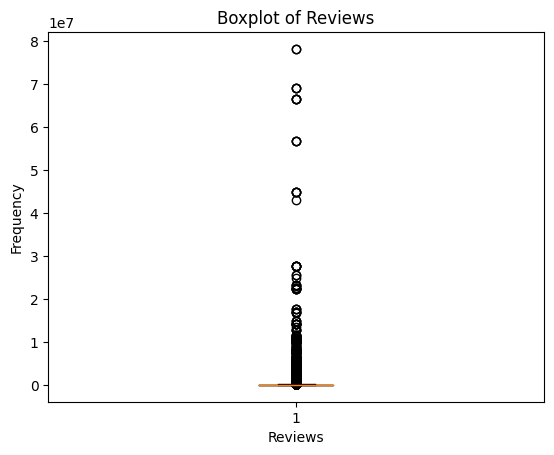

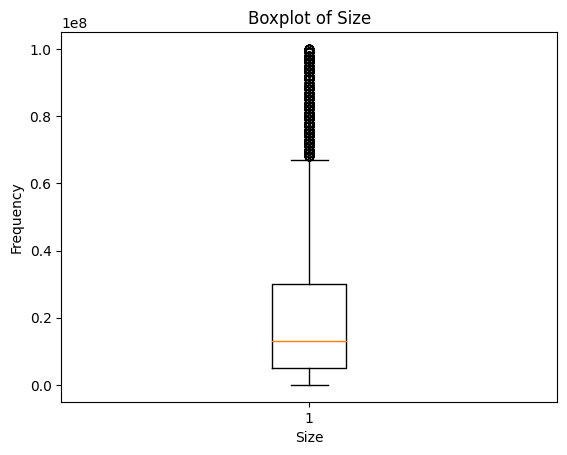

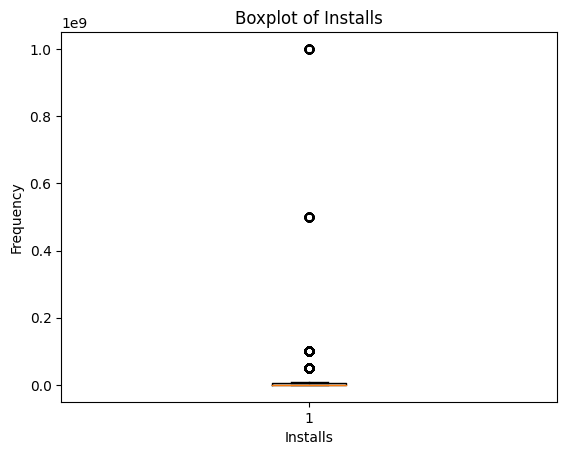

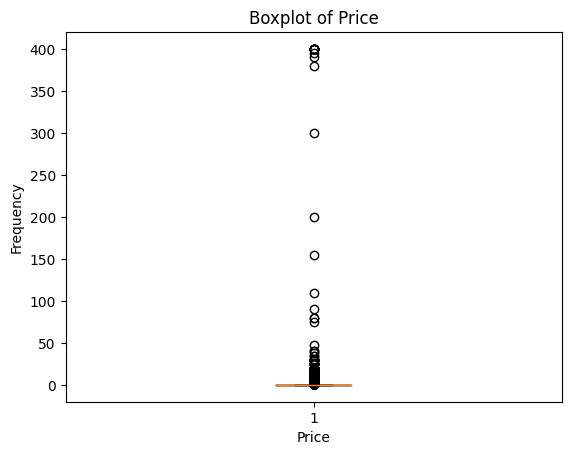

In [24]:
for key in cleaned_numerical_columns.keys():
    # get a column of data
    data = cleaned_numerical_columns[key]
    # create boxplot
    plt.boxplot(data)
    # Add labels and title
    plt.xlabel(key)
    plt.ylabel('Frequency')
    plt.title(f'Boxplot of {key}')
    plt.savefig(f'boxplot_{key}.png')
    plt.show()